# Training Pipeline
* ??

### Imports

In [134]:
import os
import joblib
import pandas as pd
import hopsworks
import weather_utils
from xgboost import XGBRegressor
from xgboost import plot_importance
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report
import time
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import numpy as np

In [195]:
df_codes_mapping = pd.read_csv("../resources/weather_code_mapping.csv")

# 1) Connect to Hopsworks Feature Store

In [135]:
# Login to Hopsworks
project = hopsworks.login()

# Retrieve Feature Store
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/178324
Connected. Call `.close()` to terminate connection gracefully.


In [136]:
# Retrieve Feature Group
weather_fg = fs.get_or_create_feature_group(
    name = 'weather_fg',
    version = 1
)

# 2) Feature View Creation and Retrieving

In [137]:
# The feature view is the input set of features for the model
feature_view = fs.get_or_create_feature_view(
    name='weather_fv',
    version=1,
    query=weather_fg.select_all()
)

# 3)Training dataset

### 3a) Create and retrieve training dataset

In [156]:
# Create a csv dataset from Hopsworks feature view
td_version, td_job = feature_view.create_training_data(
    description = 'Weather Code dataset',
    data_format = 'csv',
    write_options = {'wait_for_job': True}
)

Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/178324/jobs/named/weather_fv_1_create_fv_td_13112023111254/executions


In [158]:
# Get the previously computed dataset
X, _ = feature_view.get_training_data(
    training_dataset_version=td_version
)

print('Dataset contains', X.shape[0], 'entries')

Dataset contains 212 entries


### 3c) Split train/test set

In [159]:
# Select only model features
X = X.drop(columns=["weather_code_label", "weather_code_wmo", "date"]).fillna(0)

# Get labels of the test set
y = X.pop('weather_code')

# Split 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set contains {X_train.shape[0]} samples, '
      f'while the test set contains {X_test.shape[0]}.')

Training set contains 169 samples, while the test set contains 43.


# 4) Model training

In [160]:
# Save initial time
start_of_cell = time.time()

# Create model
xgb_model = XGBRegressor()

# Train model on the training set
xgb_model.fit(X_train, y_train)

print(f"Took {round(time.time() - start_of_cell, 2)} sec to train model.\n")

Took 0.2 sec to train model.



# 5) Model validation

### 5a) MSE, RMSE, $R^2$

In [219]:
# Predict over test set
y_pred = xgb_model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# Calculate R squared
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 5.5896134664541135
RMSE: 2.36423633895897
R2: 0.6478878679656017


### 5c) F1 score (classification)

In [233]:
# Round predicted value to closes weather code
y_pred_classified = np.round(y_pred_float).astype(int)

# Calculate F1-score
f1 = f1_score(y_test, y_pred_classified, average='weighted')
print("Weighted-averaged F1 score:", f1,'\n')

# Full F1-score report
target_names = df_codes_mapping['weather_code_label']

# Select labels of weather codes
combined_indices = np.concatenate([y_pred_classified, y_test])
selected_rows = df_codes_mapping[df_codes_mapping['weather_code'].isin(combined_indices)]
filtered_target_names = selected_rows['weather_code_label']

# Print full F1 report
f1_report = classification_report(y_test, y_pred_classified, target_names=filtered_target_names)
print(f1_report)

Weighted-averaged F1 score: 0.5389344683651018 

                                                  precision    recall  f1-score   support

       Mainly clear, partly cloudy, and overcast       0.79      0.73      0.76        15
                     Fog and depositing rime fog       0.33      0.67      0.44         3
      Rain: Slight, moderate and heavy intensity       0.00      0.00      0.00         4
Snow fall: Slight, moderate, and heavy intensity       0.00      0.00      0.00         0
                                     Snow grains       0.00      0.00      0.00         0
     Rain showers: Slight, moderate, and violent       0.89      0.47      0.62        17
                   Snow showers slight and heavy       0.00      0.00      0.00         0
                Thunderstorm: Slight or moderate       0.00      0.00      0.00         3
         Thunderstorm with slight and heavy hail       0.00      0.00      0.00         1

                                        accuracy 

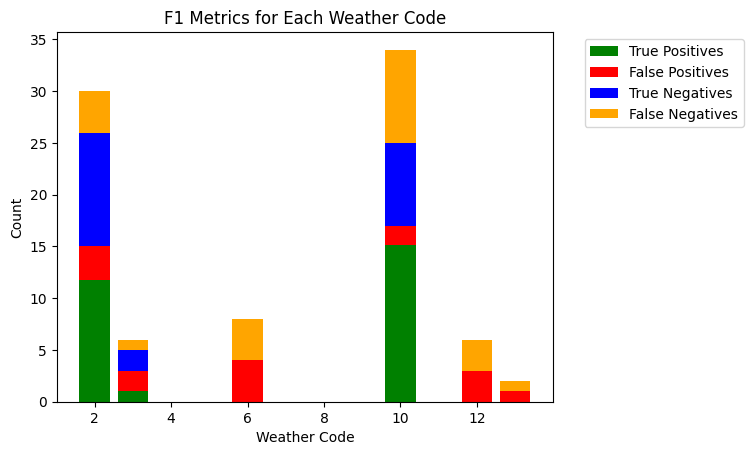

In [250]:
# Assuming you have the classification report calculated
report = classification_report(y_test, y_pred_classified, output_dict=True)

# Extract the relevant metrics for each class
classes = [int(c) for c in report.keys() if c.isdigit()]  # Extract numeric classes
tp = [report[str(c)]['precision'] * report[str(c)]['support'] for c in classes]
fp = [(1 - report[str(c)]['precision']) * report[str(c)]['support'] for c in classes]
tn = [report[str(c)]['recall'] * report[str(c)]['support'] for c in classes]
fn = [(1 - report[str(c)]['recall']) * report[str(c)]['support'] for c in classes]

# Create a stacked bar plot
fig, ax = plt.subplots()
ax.bar(classes, tp, label='True Positives', color='green')
ax.bar(classes, fp, bottom=tp, label='False Positives', color='red')
ax.bar(classes, tn, bottom=np.array(tp) + np.array(fp), label='True Negatives', color='blue')
ax.bar(classes, fn, bottom=np.array(tp) + np.array(fp) + np.array(tn), label='False Negatives', color='orange')

# Add labels and title
plt_f1.xlabel('Weather Code')
plt_f1.ylabel('Count')
plt_f1.title('F1 Metrics for Each Weather Code')

# Move the legend outside the plot using bbox_to_anchor
plt_f1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt_f1.show()

### 5d) Distribution overview

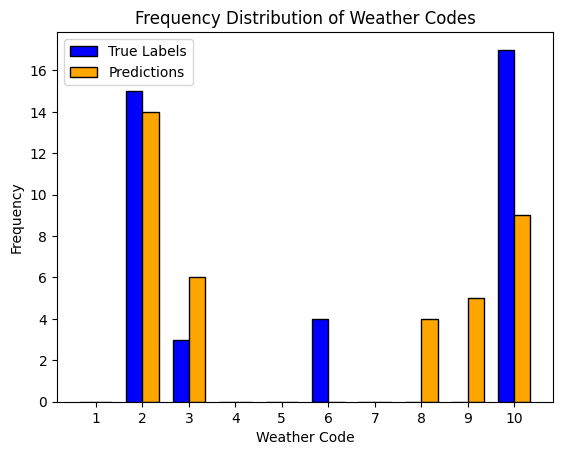

In [235]:
# Set the width of the bars
bar_width = 0.35

# Create an array for the x-axis positions
indices = np.arange(1, 11)

# Create bar plots for true labels and rounded predictions side by side
plt.bar(indices - bar_width/2, np.histogram(y_test, bins=np.arange(1, 12) - 0.5)[0], bar_width, label='True Labels', color='blue', edgecolor='black')
plt.bar(indices + bar_width/2, np.histogram(y_pred_classified, bins=np.arange(1, 12) - 0.5)[0], bar_width, label='Predictions', color='orange', edgecolor='black')

# Add labels and title
plt.xlabel('Weather Code')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Weather Codes')
plt.xticks(indices)
plt.legend()

# Show the plot
plt.show()

### 5b) Residuals

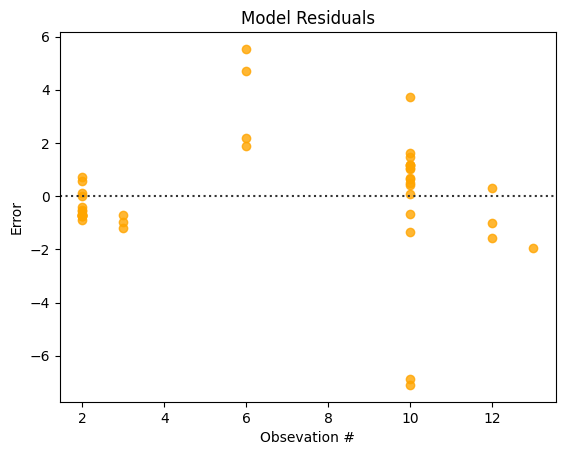

In [236]:
df_ = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})
residplot = sns.residplot(data=df_, x="y_true", y="y_pred", color='orange')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error')

plt.show()
fig_resid_plot = residplot.get_figure()
fig_resid_plot.show()

### 5c) Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

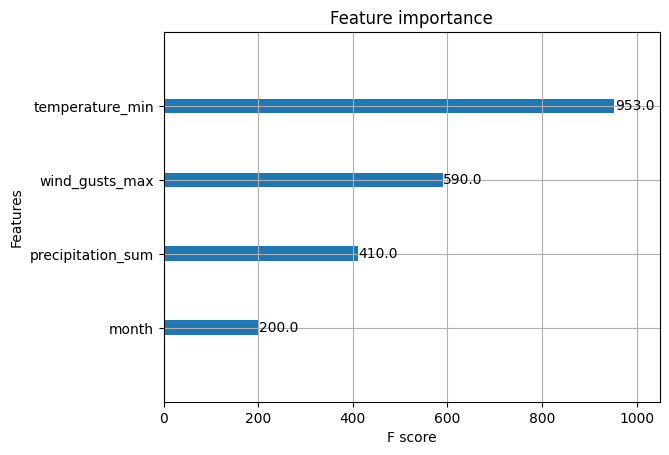

In [237]:
plot_importance(xgb_regressor)

# 6) Model Registry

In [238]:
# Retrieve model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### 6a) Model Schema

In [227]:
# Set up the Model Schema, which describes the inputs and outputs for a model
input_schema = Schema(X)
output_schema = Schema(y)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

### 6b) Save model locally

In [249]:
plt_f1.show()

In [251]:
# Set path to save model and plots
model_dir="weather_code_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save regressor model
joblib.dump(xgb_regressor, model_dir + '/xgboost_regressor.pkl')

# Save residuals plot
fig_resid_plot.savefig(model_dir + "/residplot.png") 

# Save f1 plot
plt_f1.savefig(model_dir + "/f1_plot.png")

# Save F1 report
with open(model_dir + "/f1_report.txt", 'w') as file:
    file.write(f1_report)

<Figure size 640x480 with 0 Axes>

### 6c) Upload model to Hopsworks

In [63]:
# Define model for Hopsworks
weather_code_model = mr.python.create_model(
    name="weather_code_xgboost_model", 
    metrics={
        "RMSE": rmse,
        "MSE": mse,
        "R squared": r2,
        "Weighted-averaged F1 score": f1
    },
    model_schema=model_schema, # attach model schema
    input_example=X_test.sample().values, 
    description="Weather Code predictor.")

# Upload model to Hopsworks
weather_code_model.save(model_dir)

Model export complete: 100%|████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.27s/it]

Model created, explore it at https://c.app.hopsworks.ai:443/p/178324/models/weather_code_xgboost_model/1


Model(name: 'weather_code_xgboost_model', version: 1)